In [10]:
#%pip install datasetsforecast hierarchicalforecast mlforecast neuralforecast xgboost


In [11]:
import numpy as np
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import GMM

from mlforecast import MLForecast
from mlforecast.utils import PredictionIntervals
import xgboost as xgb

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.methods import BottomUp, ERM, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import scaled_crps


In [12]:
df = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Moderna\\IQVIA\\iqvia_zip.csv')
df['Date'] = pd.to_datetime(df['Date'])

data = df
data = data.dropna()
data = data.dropna(subset=['PROVIDER_ZIP'])
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].astype(str).str.strip()
data = data[data['PROVIDER_ZIP'] != "\"\""]
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].str.replace("\"","")
data = data.sort_values(by=['PROVIDER_ZIP', 'Date'])

data['zip'] = data['PROVIDER_ZIP'].astype(str).str.split('.',expand=True)[0]
data['zip'] = np.where(data['zip'].str.len()==3,'00'+data['zip'],np.where(data['zip'].str.len()==4,'0'+data['zip'],data['zip']))
data['zip3'] = data['zip'].str.slice(stop=3)
data = data[['Date','zip3','CLM_CNT']]
data = data.groupby(['zip3','Date']).sum()

# filter on xip codes that have at least 10 data points
data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

grouped_sum = data.groupby('Date')['CLM_CNT'].transform('sum')
data['natl_admins'] = grouped_sum
data['shares'] = (data['CLM_CNT'] / data['natl_admins'])
data['country'] = 'US'
df = data

In [13]:
# Create a complete set of all possible combinations of zip3 and dates
all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='W-FRI')
all_zip3 = df['zip3'].unique()
all_country = df['country'].unique()
complete_index = pd.MultiIndex.from_product([all_country,all_zip3, all_dates], names=['country','zip3', 'Date'])

# Reindex the DataFrame to include all combinations, filling missing values with zeros
df_complete = df.set_index(['country','zip3', 'Date']).reindex(complete_index, fill_value=0).reset_index()


# Generate the dataset to match the Australian Domestic Tourism example
data = df_complete[['country','zip3', 'Date', 'CLM_CNT']].rename(columns={'Date': 'ds', 'CLM_CNT': 'y'})

# Define the hierarchical structure (this is similar to the 'spec' you used)
spec = [
    ['country'],
    ['country', 'zip3']
]

# Aggregate data according to the hierarchy
Y_df, S_df, tags = aggregate(data, spec)
Y_df = Y_df.reset_index()


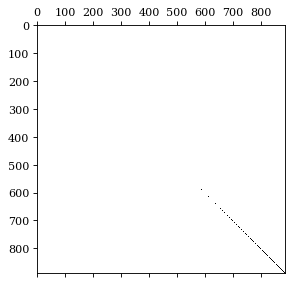

In [15]:
hplot = HierarchicalPlot(S=S_df, tags=tags)
hplot.plot_summing_matrix()


In [18]:
def sort_hier_df(Y_df, S_df):
    # sorts unique_id lexicographically
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S_df.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])
    return Y_df

Y_df = sort_hier_df(Y_df, S_df)


In [24]:
horizon = 7
Y_test_df = Y_df.groupby('unique_id').tail(horizon)
Y_train_df = Y_df.drop(Y_test_df.index)

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_29420\1045809643.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Y_test_df = Y_df.groupby('unique_id').tail(horizon)


In [28]:
level = np.arange(0, 100, 2)
qs = [[50-lv/2, 50+lv/2] for lv in level]
quantiles = np.sort(np.concatenate(qs)/100)

#fit/predict NBEATS from NeuralForecast
nbeats = NBEATS(h=horizon,
              input_size=2*horizon,
              loss=GMM(n_components=10, quantiles=quantiles),
              scaler_type='robust',
              max_steps=200)

nf = NeuralForecast(models=[nbeats], freq='W')
nf.fit(df=Y_train_df)
Y_hat_nf = nf.predict()
insample_nf = nf.predict_insample(step_size=horizon)

#fit/predict XGBRegressor from MLForecast
mf = MLForecast(models=[xgb.XGBRegressor()], 
                freq='W',
                lags=[1,2,12,24],
                date_features=['week'],
                )
mf.fit(Y_train_df, fitted=True, prediction_intervals=PredictionIntervals(n_windows=5, h=horizon)) 
Y_hat_mf = mf.predict(horizon, level=level).set_index('unique_id')
insample_mf = mf.forecast_fitted_values()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | GMM           | 100    | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.8 M  | train
-------------------------------------------------------
2.8 M     Trainable params
1.0 K     Non-trainable params
2.8 M     Total params
11.232    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\IqraImtiaz\.conda\envs\nixtla\lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ValueError: Cross validation result produced less results than expected. Please verify that the frequency set on the MLForecast constructor matches your series' and that there aren't any missing periods.